In [8]:
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from textblob import TextBlob
from textblob import Word
import seaborn as sns
import nltk
import re

In [9]:
# Leo la data desanidada y elimino las filas que son nulas en todas sus entradas
df_reviews = pq.read_table('../data2/dfreviewsOpen_compr.parquet').to_pandas()
df_reviews.drop(['0'], axis=1, inplace=True)
df_reviews = df_reviews.dropna(how='all')

In [10]:
df_reviews.head(2)

,user_id,user_url,funny,posted,last_edited,item_id,helpful,recommend,review
0,76561197970982479,http://steamcommunity.com/profiles/76561197970...,None,"Posted November 5, 2011.",None,1250.0,No ratings yet,True,Simple yet with great replayability. In my opi...
1,76561197970982479,http://steamcommunity.com/profiles/76561197970...,None,"Posted July 15, 2011.",None,22200.0,No ratings yet,True,It's unique and worth a playthrough.


In [11]:
# Elimino las filas donde la columna 'item_id' es nulo
df_reviews.dropna(subset=['item_id'], inplace=True)


In [12]:
# Reemplazo el año de 'posted' por el año en que se hizo la ultima 
# modificacion del review

# Extraigo el año de 'posted' y 'last_edited' con expresiones regulares
df_reviews['posted_year'] = df_reviews['posted'].str.extract(r'(\d{4})')
df_reviews['last_edited_year'] = df_reviews['last_edited'].str.extract(r'(\d{4})')

# Elimino las columnas originales 'posted' y 'last_edited' si lo deseas
df_reviews.drop(columns=['posted', 'last_edited','last_edited_year'], inplace=True)

# Cambio el nombre de 'posted_year' por 'posted'
df_reviews.rename(columns={'posted_year': 'posted'}, inplace=True)

# Elimino las filas donde 'posted' es nulo
df_reviews.dropna(subset=['posted'], inplace=True)

In [13]:
# Elimino columnas que no son relevantes
columnas = ['user_url','funny','helpful']
df_reviews.drop(columns=columnas, inplace=True)

In [14]:
def limpiar_y_convertir_a_minusculas(df):
    # Lista de caracteres especiales a reemplazar
    caracteres_especiales = ['-', '!', '¡', '?', '¿', '"', "'", ',', '&', "''", '_', '[', ']', ';', '(', ')','  ']

    for caracter in caracteres_especiales:
        df = df.apply(lambda x: x.str.replace(caracter, '') if x.dtype == "object" else x)

    df = df.apply(lambda x: x.astype(str).str.lower() if x.dtype == "object" else x)

    return df

In [15]:
# Guardo la columna 'user_id'
user_id = df_reviews['user_id']

In [16]:
# Convierto todas las columnas a object
df_reviews = df_reviews.apply(lambda x: x.astype(str) if x.dtype == "object" else x)

In [17]:
df_reviews = limpiar_y_convertir_a_minusculas(df_reviews)

In [18]:
# Convierto 'item_id' y 'posted' a integer
df_reviews['item_id'] = df_reviews['item_id'].astype(int)
df_reviews['posted'] = df_reviews['posted'].astype(int)

In [19]:
df_reviews['user_id'] = user_id

In [20]:
df_reviews.head(2)

,user_id,item_id,recommend,review,posted
0,76561197970982479,1250,true,simple yet with great replayability. in my opi...,2011
1,76561197970982479,22200,true,its unique and worth a playthrough.,2011


In [ ]:
# Ahora hago el analisis de sentimiento de la columna review
nltk.download('stopwords')
nltk.download('wordnet')

In [17]:
# Función para limpiar el texto de la columna 'review'
def clean_text(text):
    text = text.lower()  # Convertir a minúsculas
    text = re.sub(r'[^\w\s]', '', text)  # Eliminar caracteres especiales y puntuación
    text = ' '.join([word for word in text.split() if word not in (stopwords.words('english'))])  # Eliminar palabras de parada
    text = ' '.join([Word(word).lemmatize() for word in text.split()])  # Lematización
    
    return text

In [18]:
# Aplico limpieza a la columna 'user_reviews'
df_reviews['clean_reviews'] = df_reviews['review'].apply(clean_text)

In [19]:
# Función para el análisis de sentimiento
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity < 0:
        return 0  # Malo
    elif analysis.sentiment.polarity == 0:
        return 1  # Neutral
    else:
        return 2  # Positivo

In [20]:
# Aplico el análisis de sentimiento a la columna 'clean_reviews' y creo una nueva columna 'sentiment_analysis'
df_reviews['sentiment_analysis'] = df_reviews['clean_reviews'].apply(get_sentiment)

In [21]:
# Elimino la columna reviews
df_reviews.drop(columns='review', inplace=True)

In [25]:
df_reviews.head(2)

,user_id,item_id,recommend,posted,clean_reviews,sentiment_analysis
0,76561197970982479,1250,true,2011,simple yet great replayability opinion zombie ...,2
1,76561197970982479,22200,true,2011,unique worth playthrough,2


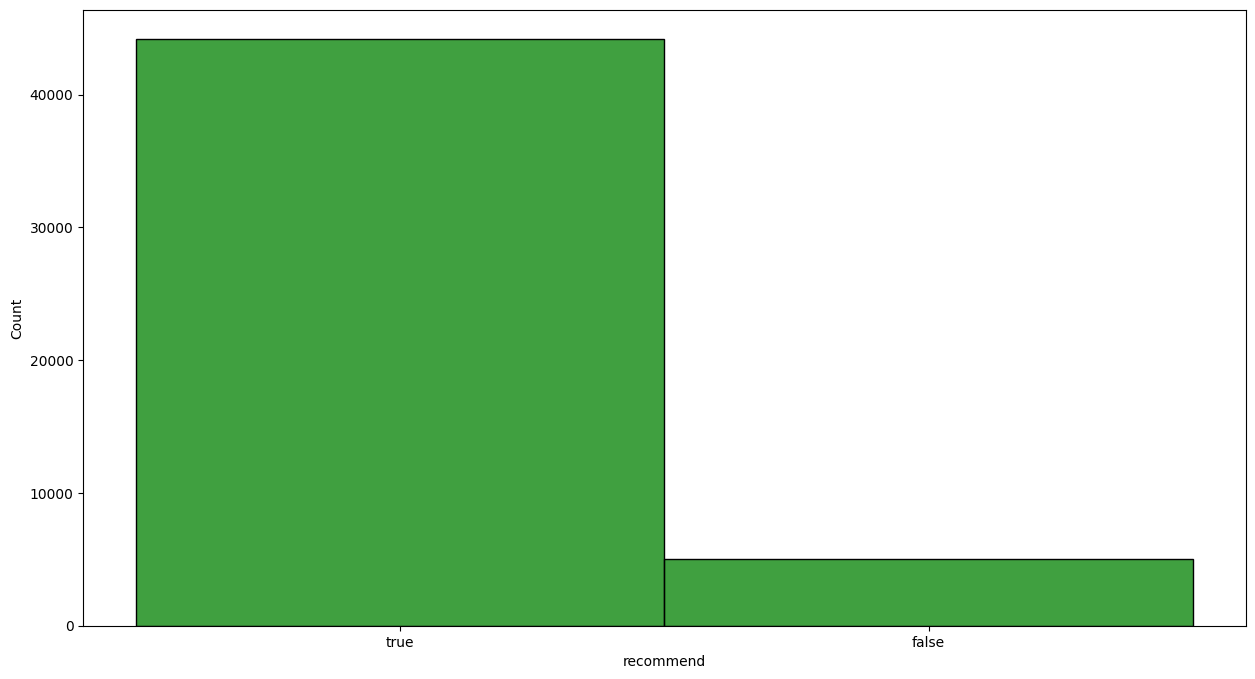

In [23]:
# Realizo un barplot de recommend, para detectar outliers

plt.figure(figsize=(15, 8))
sns.histplot(data=df_reviews, x='recommend', bins=50, color='g')
plt.show()

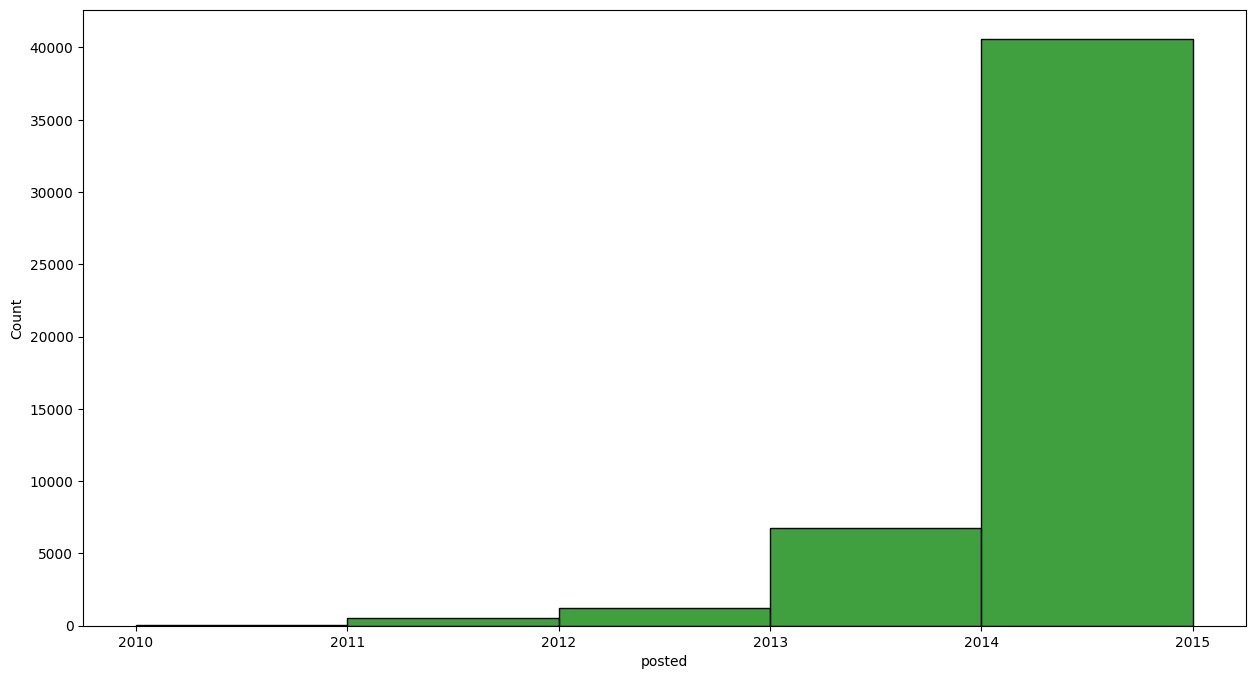

In [24]:
# Realizo un histograma de posted, para detectar outliers

plt.figure(figsize=(15, 8))
sns.histplot(data=df_reviews, x='posted', bins=5, color='g')
plt.show()

In [27]:
# Guardo el dataset procesado para su posterior uso
df_reviews.to_parquet('../data2/df_reviews_limpio_compr.parquet')